# Individual part of the IDH project

This is the Jupyter notebook for the individual part of the project for the Introduction to Digital Humanities course at KU Leuven, 2025.
The goal is to analyze various asspects of different languages appearing in the database.

## Setting up Python

We will first import all libraries needed for the project.

In [1]:
# Pandas is used for data analysis.
import pandas as pd
# Langdetect is used to detect the language of a string.
import langdetect as ld
# Tabulate for nicer printing of tables
from tabulate import tabulate
# SpaCy for language analysis
import spacy
# Gensim for topic modelling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

Here are the links to the libraries:
- Pandas - https://pandas.pydata.org/
- langdetect - https://pypi.org/project/langdetect/ 
- tabulate - https://pypi.org/project/tabulate/
- SpaCy - https://spacy.io/
- Gensim - https://radimrehurek.com/gensim/

## Importing the data

First we shall import the data as a Pandas dataframe and inspect it. Note that we set the parameter `low_memory`to *False* to avoid problems with datatypes (although one should be careful with using this and maybe resort to setting the `dtype` parameter - `low_memory` works fine in our case, though).  

In [2]:
books_df = pd.read_csv("All-merged-authors-imprint-title-clean-reconciled.csv", sep=",", low_memory=False, encoding="utf-8")

In [3]:
#Inspect the first five rows
books_df.head(5)

,File,Aleph system no.,Country code,Language code (008),Language code (041),DDC,Personal-author_ORIGINAL,Personal-author_clean,Personal_author_clean_URL,Personal_author_title,...,Date,Location_intermediate,Series,Subjects,Other personal authors,Other corporate authors,DOM ID,Type,Genre,Column
0,drama.xlsx,14602858,|||,und,NaN,NaN,"Inchbald, Mrs., 1753-1821","Inchbald, Mrs",NaN,NaN,...,1791.0,London,NaN,NaN,"Destouches, Néricault, 1680-1754",NaN,lsidyv2eb18738,comedy,Drama,NaN
1,drama.xlsx,14605599,|||,und,NaN,NaN,NaN,NaN,NaN,NaN,...,1809.0,London,NaN,NaN,NaN,NaN,lsidyv3031fb89,comedy,Drama,NaN
2,drama.xlsx,14608193,|||,und,NaN,NaN,"CLARIS DE FLORIAN, Jean Pierre.",Jean-Pierre Claris de Florian,https://www.wikidata.org/wiki/Q551740,NaN,...,1788.0,London Harrison,NaN,NaN,"CLARIS DE FLORIAN, Jean Pierre. -- Robson, Hor...",NaN,lsidyv3097b1af,comedy,Drama,NaN
3,drama.xlsx,14608240,|||,und,NaN,NaN,NaN,NaN,NaN,NaN,...,1641.0,NaN,NaN,NaN,"Brathwaite, Richard, 1588?-1673.",NaN,lsidyv32b79f0b,comedy,Drama,NaN
4,drama.xlsx,14608260,|||,und,NaN,NaN,"Sedaine, 1719-1797",Michel-Jean Sedaine,https://www.wikidata.org/wiki/Q367243,NaN,...,1788.0,London,NaN,NaN,NaN,NaN,lsidyv32b62fd6,comedy,Drama,NaN


Let's inspect the names of the columns so we can use them more easily in the future.

In [4]:
list(books_df)

['File',
 'Aleph system no.',
 'Country code',
 'Language code (008)',
 'Language code (041)',
 'DDC',
 'Personal-author_ORIGINAL',
 'Personal-author_clean',
 'Personal_author_clean_URL',
 'Personal_author_title',
 'Personal_author_years',
 'Personal_author_floruit',
 'Personal_author_DoB',
 'Personal_author_DoD',
 'Personal_author_pseudonym',
 'Corporate author',
 'Title_ORIGINAL',
 'Title_clean',
 'Title_clean_after_By',
 'Title_clean_language_detected',
 'Edition',
 'Imprint_ORIGINAL',
 'Location_clean',
 'Location_clean_URL',
 'Date',
 'Location_intermediate',
 'Series',
 'Subjects',
 'Other personal authors',
 'Other corporate authors',
 'DOM ID',
 'Type',
 'Genre',
 'Column']

## Exploring languages

We have three columns which can tell us something about language in the dataset: ``. We first add a fourth column, using `langdetect` module. We will iterate through the `Title_clean`column and use it to detect the language of the title. If the language cannot be detected, we set the value as 'Error'. Seeing as `langdetect` is non deterministic (which can become obvious when used on short strings), we will first make small adjustements to get consistent results.

In [5]:
# Setting seed to get consistent results
from langdetect import DetectorFactory
DetectorFactory.seed = 1984

In [6]:
langlist_ld = []
# Iterate through book titles and detect language for every title
for i, t in books_df['Title_clean'].items():
    try:
        langlist_ld.append(ld.detect(t))
    # On error, add 'Error' as languge
    except:
        langlist_ld.append("Error")

In [7]:
# Count the number of errors while langugae detecting 
langlist_ld.count("Error")

67

In [8]:
# Insert the new list of detected languages as a column to the DF.
books_df["py-lang-det"] = langlist_ld

We now have four columns. First two columns, `Language code (008)` and `(041)` contain information on the language of the book itself, not of the title. In addition, the `(041)` column has considerably less data than other columns which will make it harder to compare it with the other three. 

In [9]:
count041 = books_df['Language code (041)'].count()
print(f"There are {count041} non-zero values in the 'Language code (041)' column, which is about {round(count041/len(books_df['Language code (041)'])*100, 2)}% of all rows.")

There are 596 non-zero values in the 'Language code (041)' column, which is about 1.21% of all rows.


The other two columns gives us information on language detection of the titles. The `Title_clean_language_detected` column was made using the Google API, while the `py-lang-det` column contains data generate by the module in the code above.

Let's perform some basic descriptive statistics on these three.

In [10]:
# Assign the three remaining columns of interest to their variables
langs_google = books_df['Title_clean_language_detected']
langs_py = books_df['py-lang-det']
langs_data = books_df['Language code (008)']

In [11]:
# Count number of non-empty values in columns and count unique values (i.e. recognized languaes)
lang_df_info = [
    ['Google', langs_google.count(), langs_google.nunique()],
    ['Python', langs_py.count(), langs_py.nunique()],
    ['Data', langs_data.count(), langs_data.nunique()]
]
ldi_head = ['Tool', 'Total len', 'uniques']
print(tabulate(lang_df_info, headers=ldi_head, tablefmt="grid"))

+--------+-------------+-----------+
| Tool   |   Total len |   uniques |
+========+=============+===========+
| Google |       49455 |       105 |
+--------+-------------+-----------+
| Python |       49455 |        38 |
+--------+-------------+-----------+
| Data   |       49455 |        28 |
+--------+-------------+-----------+


We can see that these columns greatly differ one from another. Let's inspect which languages do they report as the most frequent.

In [12]:
langs_google.value_counts(normalize = True)[0:6]

Title_clean_language_detected
eng    0.750763
fre    0.081953
ger    0.068648
ita    0.015529
spa    0.015347
dut    0.011950
Name: proportion, dtype: float64

In [13]:
langs_py.value_counts(normalize = True)[0:6]

py-lang-det
en    0.716652
fr    0.086382
de    0.075705
it    0.019978
nl    0.017187
es    0.016156
Name: proportion, dtype: float64

In [14]:
langs_data.value_counts(normalize = True)[0:6]

Language code (008)
eng    0.389243
und    0.381701
fre    0.077505
ger    0.063917
spa    0.015549
ita    0.012981
Name: proportion, dtype: float64

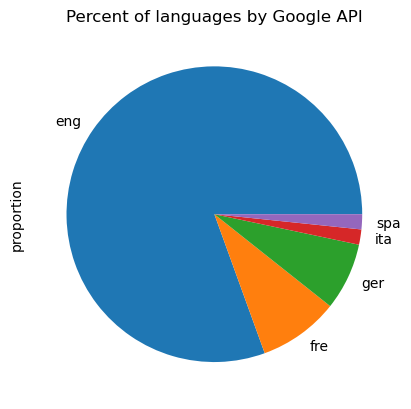

In [15]:
# Make charts out of these
lang_google_plot = langs_google.value_counts(normalize = True)[0:5].plot(kind='pie', title = "Percent of languages by Google API")

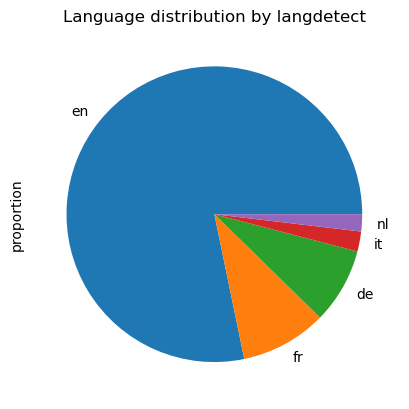

In [16]:
lang_py_plot = langs_py.value_counts(normalize = True)[0:5].plot(kind='pie', title = "Language distribution by langdetect")

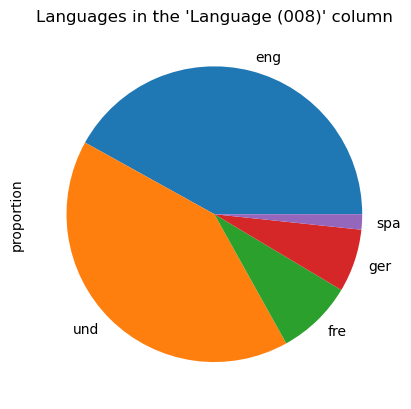

In [17]:
lang_data_plot = langs_data.value_counts(normalize = True)[0:5].plot(kind='pie', title = "Languages in the 'Language (008)' column")

In [18]:
# Save charts as usable files
lang_google_plot.figure.savefig('lang-google-perc.jpg')
lang_py_plot.figure.savefig('lang-py-perc.jpg')
lang_data_plot.figure.savefig('lang-data-perc.jpg')

## Languages ~ Genre

Before moving on to topic analysis, let's see the distribution of different genres for English, French and German. Genre is usually closely correlated to the topic of a book so it will be useful to compare this to the topic modeling results.

In [19]:
pd.crosstab(books_df['py-lang-det'].loc[books_df['py-lang-det'] == "en"],
            books_df['Genre'], 
            normalize =True)

Genre,Drama,Music,Poetry,Prose
py-lang-det,,,,
en,0.092403,0.050824,0.303534,0.553239


In [20]:
pd.crosstab(books_df['py-lang-det'].loc[books_df['py-lang-det'] == "fr"],
            books_df['Genre'], 
            normalize =True)

Genre,Drama,Music,Poetry,Prose
py-lang-det,,,,
fr,0.034483,0.01061,0.525199,0.429708


In [21]:
pd.crosstab(books_df['py-lang-det'].loc[books_df['py-lang-det'] == "de"],
            books_df['Genre'], 
            normalize =True)

Genre,Drama,Music,Poetry,Prose
py-lang-det,,,,
de,0.013928,0.041783,0.632312,0.311978


**NOTA BENE**: We must be careful when interpreting these results, because the large majority of books comes from the 'nongenre' collection and thus lacks a genre value. 

In [22]:
books_df.groupby("File")['File'].value_counts()

File
drama.xlsx       1647
music.xlsx        936
nogenre.xlsx    30146
poetry.xls      16726
Name: count, dtype: int64

<Axes: ylabel='count'>

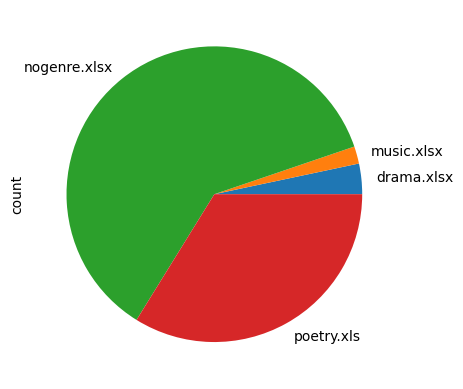

In [23]:
books_df.groupby("File")['File'].value_counts().plot(kind="pie")

### Title length by genre and lanugage

The length of titles in each genre will also be important for our analysis and comparison. For that reason we will extract the length of each title and add it to our dataframe. We will then see the average length in general and for each genre. 

**NOTE**: We use the English model of Spacy for each title, assuming it will give us a good estimate of tokens for all languages.

In [24]:
nlp_titles = spacy.load("en_core_web_sm", disable=['ner', 'lemmatizer', 'tagger', 'parser', 'textcat'])

In [25]:
# Create a list for titles
titles_len = []
for t in books_df['Title_clean']:
    try:
        title_tokens = []
        t_nlp = nlp_titles(t) #Analyze titles using Spacy object
        for token in t_nlp:
            title_tokens.append(token) #Turn each title into a list of tokens
        titles_len.append(len(title_tokens)) #Save the number of tokens in the list
    except:
        titles_len.append(1)

In [26]:
# Save the length of titles 
books_df['Title_length'] = titles_len

In [27]:
print (f'The average title is around {round(sum(titles_len)/len(titles_len), 2)} tokens long')

The average title is around 15.48 tokens long


We can also inspect average title length per genre and original file.

In [28]:
books_df.groupby("Genre")['Title_length'].mean()

Genre
Drama     14.647845
Music     19.047959
Poetry    15.292358
Prose     12.834030
Name: Title_length, dtype: float64

In [29]:
books_df.groupby("File")['Title_length'].mean()

File
drama.xlsx      14.647845
music.xlsx      19.233974
nogenre.xlsx    16.364095
poetry.xls      13.743872
Name: Title_length, dtype: float64

## Analyzing the titles

Having in mind all that we saw above, we will use the `lang-py-det` column to detect language of the title. We will perform topic analysis on English, French and German, because they have enough titles to gather sensible data.

For this purpse we will use `spaCy` to preprocess the titles (it has a good support for all these three languages) and `Gensim` to perform the topic modelling.

The whole process was heavily based on and inspired by the online tutorial on topic modelling, [*Topic Modeling with Python (Gensim & SpaCy)*](https://learn.scds.ca/text-analysis-3/lessons/tmpython.html), a part of the *Exploring Themes with Topic Modeling* workshop from a series of workshops on computational text analysis by [*The Sherman Centre for Digital Scholarship*](https://scds.ca/).

An important change in respect to the tutorial above is that we do not use the [LDA model](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0/), but opt for the [NMF](https://medium.com/@sophiamsac/understanding-nmf-for-simple-topic-modelling-b3d7bc4f3fc2), inspired by [this article](https://medium.com/@vlad.andreichuk/non-negative-matrix-factorization-nmf-for-the-grouping-of-articles-titles-a73e654b6244) (and some very bad results using LDA).

### English

First we will preprocess titles using SpaCy and Genism. We are using the `en_core_web_lg` model. We extract the titles and use functions (taken from the [tutorial](https://learn.scds.ca/text-analysis-3/lessons/tmpython.html)).

In [30]:
# Extract the English titles, based on the 'py-lang-det' column, the one we created using langdetect
en_titles = books_df['Title_clean'].loc[books_df["py-lang-det"] == "en"]

In [31]:
# Load the nlp pipeline, omitting the parser and ner steps of the workflow to conserve computer memory
nlp_en = spacy.load("en_core_web_lg", disable=["parser", "ner"])

In [32]:
titles_len_en = []
for t in en_titles:
    try:
        title_tokens = []
        t_nlp = nlp_en(t)
        for token in t_nlp:
            title_tokens.append(token)
        titles_len_en.append(len(title_tokens))
    except:
        titles_len_en.append(1)

In [33]:
print(f'Based on our languages detection, there are {len(en_titles)} English titles. The average title is around {round(sum(titles_len_en)/len(titles_len_en), 2)} tokens long.')

Based on our languages detection, there are 35442 English titles. The average title is around 16.0 tokens long.


We will first define the [lemmatization function](https://learn.scds.ca/text-analysis-3/lessons/tmpython.html#step5). It takes the texts (in our case the titles), and lemmatizes them, skiping function words (see `allowed_postags`) and certain lemmas (see `forbidden_lemmas`). The lemmas to skip were chosen after initial testings to get better results in topic modelling. 

In [34]:
def lemmatization_en (texts, 
                  allowed_postags=["NOUN", "ADJ", "VERB", "ADV"], 
                  forbidden_lemmas=['edit', 'edition', 'second', 'third', 'illustrate', 'illustrated', 'illustration', 'reprint', 'introduction', 'other']):   
    # Doing part of speech (PoS) tagging helps with lemmatization
    texts_out = []
    for text in texts: # Run each of the documents through the nlp pipeline
        doc = nlp_en(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags and token.lemma_ not in forbidden_lemmas:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [35]:
en_lemmatized_texts = lemmatization_en(en_titles)

After lemmatization, we perform [additional processing](https://learn.scds.ca/text-analysis-3/lessons/tmpython.html#step5), basically using Gensim's `simple_preprocess` to remove accents and get better formed tokens.

In [36]:
def gen_words(texts):
    final = [] # Create an empty list to hold tokens
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc = True) 
        # If working with languages that employ accents, you can set deacc to False
        final.append(new)
    return (final)

In [37]:
en_data_words = gen_words(en_lemmatized_texts)

Still following the tutorial, we form bigrams and trigram from frequently occuring phrases. While this is maybe not as necessary for our short book titles, it can be useful. 

In [38]:
en_bigram_phrases = gensim.models.Phrases(en_data_words, min_count=3, threshold=50)
en_trigram_phrases = gensim.models.Phrases(en_bigram_phrases[en_data_words], threshold=50)

en_bigram = gensim.models.phrases.Phraser(en_bigram_phrases)
en_trigram = gensim.models.phrases.Phraser(en_trigram_phrases)

def make_bigrams(texts):
    return [en_bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [en_trigram[en_bigram[doc]] for doc in texts]

en_data_bigrams = make_bigrams(en_data_words)
en_data_bigrams_trigrams = make_trigrams(en_data_bigrams)

Next, we [build a dictionary](https://learn.scds.ca/text-analysis-3/lessons/tmpython.html#step8) from the processed data, where we the key is a unique identifier of each word appearing in our titles and the value is number of counts/occurences of each of these word.

Here we diverge from the tutorial and add an additional step to the process - we transform the terms in the dictionary using the TF-IDF model to get better result in the NMF analysis later.

In [39]:
# Create dictionary of all words in texts
en_id2word = corpora.Dictionary(en_data_bigrams_trigrams)

# Represent dictionary words as tuples (index, frequency)
en_corpus = []
for text in en_data_bigrams_trigrams:
    new = en_id2word.doc2bow(text)
    en_corpus.append(new)

en_tfidf = gensim.models.TfidfModel(en_corpus)
en_corpus_tfidf = en_tfidf[en_corpus]

We finally implement the NMF model and get the topics.

In [40]:
# Create NMF model
en_nmf_model = gensim.models.nmf.Nmf(corpus=en_corpus_tfidf, #Specify the corpus
                                            id2word=en_id2word, #Specify the dictionary
                                            num_topics=7, #Specify number of topics
                                            random_state = 1986, #Set seed for reproducibility
                                            chunksize=3000, #Number of segments (titles) to be used in training
                                            passes=100, #Number of full passes over the corpus       
                                            kappa=0.1 # Set gradient descent step)

# Print topics
en_nmf_model.show_topics()

SyntaxError: '(' was never closed (726993391.py, line 2)

### German

We repeat the same process for German with slight adjustments. We use SpaCy's `de_core_news_lg` model.

In [ ]:
de_titles = books_df['Title_clean'].loc[books_df["py-lang-det"] == "de"]

In [ ]:
nlp_de = spacy.load("de_core_news_lg", disable=["parser", "ner"])

In [ ]:
titles_len_de = []
for t in en_titles:
    try:
        title_tokens = []
        t_nlp = nlp_de(t)
        for token in t_nlp:
            title_tokens.append(token)
        titles_len_de.append(len(title_tokens))
    except:
        titles_len_de.append(1)

In [ ]:
print(f'Based on our languages detection, there are {len(de_titles)} German titles. The average title is around {round(sum(titles_len_de)/len(titles_len_de), 2)} tokens long.')

In [ ]:
def lemmatization_de (texts, 
                  allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):   
    # Doing part of speech (PoS) tagging helps with lemmatization
    texts_out = []
    for text in texts: # Run each of the documents through the nlp pipeline
        doc = nlp_de(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags and token.lemma_ != "etc.":
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [ ]:
de_lemmatized_texts = lemmatization_de(de_titles)

We adjuts the `gen_words` function to keep the accesnts in French and German (in case accent removal also removes 'umlauts').

In [ ]:
def gen_words_defr(texts):
    final = [] # Create an empty list to hold tokens
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc = False) 
        # If working with languages that employ accents, you can set deacc to False
        final.append(new)
    return (final)

In [ ]:
de_data_words = gen_words_defr(de_lemmatized_texts)

In [ ]:
de_bigram_phrases = gensim.models.Phrases(de_data_words, min_count=3, threshold=50)
de_trigram_phrases = gensim.models.Phrases(de_bigram_phrases[de_data_words], threshold=50)

de_bigram = gensim.models.phrases.Phraser(de_bigram_phrases)
de_trigram = gensim.models.phrases.Phraser(de_trigram_phrases)

def make_bigrams(texts):
    return [de_bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [de_trigram[de_bigram[doc]] for doc in texts]

de_data_bigrams = make_bigrams(de_data_words)
de_data_bigrams_trigrams = make_trigrams(de_data_bigrams)

In [ ]:
# Create dictionary of all words in texts
de_id2word = corpora.Dictionary(de_data_bigrams_trigrams)

# Represent dictionary words as tuples (index, frequency)
de_corpus = []
for text in de_data_bigrams_trigrams:
    new = de_id2word.doc2bow(text)
    de_corpus.append(new)

de_tfidf = gensim.models.TfidfModel(de_corpus)
de_corpus_tfidf = de_tfidf[de_corpus]

In [ ]:
# Create NMF model
de_nmf_model = gensim.models.nmf.Nmf(corpus=de_corpus_tfidf,
                                            id2word=de_id2word,
                                            num_topics=7,
                                            random_state = 1986,
                                            chunksize=3000,     
                                            passes=100,         
                                            kappa=0.1)

# Print topics
de_nmf_model.show_topics()

### French

We repeat the process for French, using the `fr_core_news_lg` model.

In [ ]:
fr_titles = books_df['Title_clean'].loc[books_df["py-lang-det"] == "fr"]

In [ ]:
nlp_fr = spacy.load("fr_core_news_lg", disable=["parser", "ner"])

In [ ]:
titles_len_fr = []
for t in en_titles:
    try:
        title_tokens = []
        t_nlp = nlp_fr(t)
        for token in t_nlp:
            title_tokens.append(token)
        titles_len_fr.append(len(title_tokens))eel
    except:
        titles_len_fr.append(1)

In [ ]:
print(f'Based on our languages detection, there are {len(fr_titles)} French titles. The average title is around {round(sum(titles_len_fr)/len(titles_len_fr), 2)} tokens long.')

In [ ]:
def lemmatization_fr (texts, 
                  allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):   
    # Doing part of speech (PoS) tagging helps with lemmatization
    texts_out = []
    for text in texts: # Run each of the documents through the nlp pipeline
        doc = nlp_fr(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags and token.lemma_ not in ["etc.", "publier", "édition"]:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [ ]:
fr_lemmatized_texts = lemmatization_fr(fr_titles)

In [ ]:
fr_data_words = gen_words_defr(fr_lemmatized_texts)

In [ ]:
fr_bigram_phrases = gensim.models.Phrases(fr_data_words, min_count=3, threshold=50)
fr_trigram_phrases = gensim.models.Phrases(fr_bigram_phrases[fr_data_words], threshold=50)

fr_bigram = gensim.models.phrases.Phraser(fr_bigram_phrases)
fr_trigram = gensim.models.phrases.Phraser(fr_trigram_phrases)

def make_bigrams(texts):
    return [fr_bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [fr_trigram[fr_bigram[doc]] for doc in texts]

fr_data_bigrams = make_bigrams(fr_data_words)
fr_data_bigrams_trigrams = make_trigrams(fr_data_bigrams)

In [ ]:
# Create dictionary of all words in texts
fr_id2word = corpora.Dictionary(fr_data_bigrams_trigrams)

# Represent dictionary words as tuples (index, frequency)
fr_corpus = []
for text in fr_data_bigrams_trigrams:
    new = fr_id2word.doc2bow(text)
    fr_corpus.append(new)

fr_tfidf = gensim.models.TfidfModel(fr_corpus)
fr_corpus_tfidf = fr_tfidf[fr_corpus]

In [ ]:
# Create NMF model
fr_nmf_model = gensim.models.nmf.Nmf(corpus=fr_corpus_tfidf,
                                            id2word=fr_id2word,
                                            num_topics=7,
                                            random_state = 1986,
                                            chunksize=3000,     
                                            passes=100,         
                                            kappa=0.1)

# Print topics
fr_nmf_model.show_topics()